In [1]:
import numpy as np 
from PIL import ImageGrab
import cv2
import time
from numpy import ones, vstack
from numpy.linalg import lstsq
import pyautogui
from statistics import mean
import imutils
import matplotlib.pyplot as plt
import time

In [2]:
from directkeys import PressKey, LEFT, RIGHT, SPACE, Z, ESC

In [3]:
def roi(img, vertices):
    
    #blank mask:
    mask = np.zeros_like(img)   
    
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, 255)
    
    #returning the image only where mask pixels are nonzero
    masked = cv2.bitwise_and(img, mask)
    return masked

def process_img(image):
    original_image = image
    # convert to gray
    processed_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # edge detection
    processed_img =  cv2.Canny(processed_img, threshold1 = 200, threshold2=300)
    
    processed_img = cv2.GaussianBlur(processed_img,(5,5),0)
    
    vertices = np.array([[0,850],[0,65],[925,65],[925,850],
                         ], np.int32)

    processed_img = roi(processed_img, [vertices])

    # more info: http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html
    #                                     rho   theta   thresh  min length, max gap:        
    lines = cv2.HoughLinesP(processed_img, 1, np.pi/180, 180,      20,       15)
    draw_lines (process_img,lines)
    return processed_img

In [4]:
def draw_lines(img,lines):
    try:
        for line in lines:
            coords = line[0]
            cv2.line(img,(coords[0],coords[1]),(coords[2],coords[3]), [255,255,255],3)
    except:
        pass

Create pyramid of image to help with classification

In [11]:
def pyramid(image, scale=1.5, minSize=(30, 30)):
    # yield the original image
    yield image
 
    # keep looping over the pyramid
    while True:
        # compute the new dimensions of the image and resize it
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)

        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break

        # yield the next image in the pyramid
        yield image

Sliding Window Function

In [12]:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
        # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [13]:
# Malisiewicz et al.
def non_max_suppression_fast(boxes,labels,overlapThresh):
# if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
        
    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
 
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        #only delete overlapping boxes that have been classified as the same
        found_overlaps = np.where(overlap > overlapThresh)[0]
        if found_overlaps.shape > (1,):
            for i in found_overlaps:
                for j in found_overlaps:
                    if i != j and labels[i][0] == labels[j][0]:
                        found_overlaps = []

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
        found_overlaps)))

    # return only the bounding boxes that were picked using the
    # integer data type
    return pick,boxes[pick].astype("int")

# Load Model and Predict

In [14]:
import N_Game_func
import keras

W0102 20:13:29.406698  2196 __init__.py:690] 

  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  
Using TensorFlow backend.


In [15]:
parent_dir = 'C:\\Users\\Jordan\\Desktop\\N_game_images\\'

In [16]:
labels,merged_labels = N_Game_func.original_labels(parent_dir)

In [17]:
model=keras.models.load_model(parent_dir+'models\\preTrained_VGG_trainLast3_Generator.h5')

W0102 20:13:30.702289  2196 module_wrapper.py:137] From C:\Users\Jordan\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0102 20:13:30.741271  2196 module_wrapper.py:137] From C:\Users\Jordan\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0102 20:13:31.507528  2196 module_wrapper.py:137] From C:\Users\Jordan\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0102 20:13:31.567398  2196 deprecation.py:323] From C:\Users\Jordan\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow_core\python\ops\math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed

In [18]:
model.load_weights(parent_dir+'check_points\\preTrained_VGG_trainLast3_Generator_weights-improvement-36-0.83.hdf5')

Draws rectangle over sliding window and labels window's classification

In [19]:
(winW, winH) = (30, 30)

In [20]:

#for i,sub_img in enumerate(pyramid(screen)):
def classify_screen(screen,model,labels,tolerance=0.8,winSize = (30,30),
                   winStep = 32,screenResize = (800,500)):
    sub_img=cv2.resize(screen,screenResize)
    #start = time.time()

    classd_positions = []
    classd_labels = []
    # loop over the sliding window for each layer of the pyramid
    for (x, y, window) in sliding_window(sub_img, stepSize=winStep, 
                                         windowSize=winSize):

        # if the window does not meet our desired window size, ignore it
        if window.shape[0] != winH or window.shape[1] != winW:
            continue

        test_window = cv2.resize(window,model.input_shape[1:3])
        test_img = np.expand_dims(test_window,0)
        prediction = model.predict(test_img/255.)

        conf = np.max(prediction)

        if conf > tolerance:
            classd_positions.append([x,y,x+winW,y+winH])

            classified_label = labels[np.argmax(prediction)]
            classd_labels.append([classified_label,conf])

    if not classd_positions:
        raise Exception("NO PREDICTIONS MADE")
    #filter overlapping boxes
    classd_positions = np.array(classd_positions)
    boxIdx,no_overlapBoxes = non_max_suppression_fast(classd_positions,
                                                      classd_labels,.2)

    #filter/sort labels according to boxes idx
    array_labels = np.array(classd_labels)
    classd_labels = array_labels[boxIdx]

    #get confidence values for N character detection
    n_conf = [lab[1] for lab in classd_labels if 'N' in lab]
    switch_conf = [lab[1] for lab in classd_labels if 'Switch' in lab]
    OD_conf = [lab[1] for lab in classd_labels if 'OD' in lab]
    dup_idx = []
    for idx,lab in enumerate(classd_labels):
        if 'N' in lab and max(n_conf) not in lab:
            dup_idx = np.append(dup_idx,idx)
        elif 'Switch' in lab and max(switch_conf) not in lab:
            dup_idx = np.append(dup_idx,idx)
        elif 'OD' in lab and max(OD_conf) not in lab:
            dup_idx = np.append(dup_idx,idx)

    classd_labels = np.delete(classd_labels,dup_idx,0)
    no_overlapBoxes = np.delete(no_overlapBoxes,dup_idx,0)

    #draw predictions on image
    clone=sub_img.copy()
    for n,pos in enumerate(no_overlapBoxes):
        x1 = pos[0]
        y1 = pos[1]
        x2 = pos[2]
        y2 = pos[3]

        label = classd_labels[n][0]
        percent = float(classd_labels[n][1])*100

        img_text = "{}:{:2.0f}%".format(label,percent)

        cv2.rectangle(clone,(x1,y1), (x2,y2),(0,255,0),2)
        cv2.putText(clone,img_text,(x1,y1),cv2.FONT_HERSHEY_SIMPLEX,0.3,
                   (255,255,255), lineType=cv2.LINE_AA)

    #print("--- %s seconds ---" % (time.time() - start))
    #cv2.imshow("Window",clone)
    #if cv2.waitKey(0)==ord('c'):
        #continue
    #elif cv2.waitKey(0)==ord('q'):
        #cv2.destroyAllWindows()
        #break

    #cv2.destroyAllWindows()
        #clone = resized.copy()
        #cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
        #cv2.putText(clone, classified_label, (x, y+winH), cv2.FONT_HERSHEY_SIMPLEX, 1.0, 
                        #(255, 255, 255), lineType=cv2.LINE_AA) 
        #cv2.imshow("Window", clone)
        #k=cv2.waitKey(0)
        #if k==ord('a'):
            #time.sleep(0.025)
        #elif k == ord('q'):
            #cv2.destroyAllWindows()
            #break

    #cv2.destroyAllWindows()
    return clone,classd_labels

# Run

In [5]:
def main():
    last_time = time.time()
    while True:
        #PressKey(RIGHT)
        screen = np.array(ImageGrab.grab(bbox=(0,100,950,830)))
        
        try:
            clone,detected_labs = classify_screen(screen,model,
                                                  merged_labels,
                                                 tolerance = .1)
            cv2.imshow('window2',clone)
        except:
            clone = screen

        print('Frame took {} seconds'.format(time.time()-last_time))
        last_time = time.time()
        #new_screen = process_img(screen)
        #cv2.imshow('window', new_screen)
        
        #cv2.imshow('window',cv2.cvtColor(screen, cv2.COLOR_BGR2RGB))
        #press q to close screen
        if cv2.waitKey(25) & 0xFF == ord('q'):
            cv2.destroyAllWindows()
            break

In [43]:
screen = np.array(ImageGrab.grab(bbox=(0,60,930,800)))

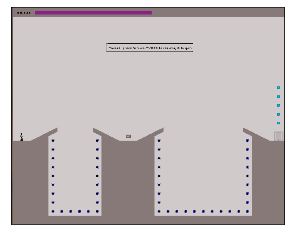

In [44]:
plt.xticks([])
plt.yticks([])
plt.imshow(cv2.cvtColor(screen, cv2.COLOR_BGR2RGB))

In [45]:
screen = imutils.resize(screen,width=int(633/1.5))

In [47]:
clone,detected_labs = classify_screen(screen,model,
                                                  merged_labels,
                                                 tolerance = .5)
cv2.imshow('Window',clone)
if cv2.waitKey(0) == ord('q'):
    cv2.destroyAllWindows()

C:\Users\Jordan\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
C:\Users\Jordan\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


In [ ]:
main()

In [ ]:
cv2.destroyAllWindows()